## Jupyter notebook for testing an image

Code from [tests/test_snapshot.py](tests/test_snapshot.py)

required packages 

1. Tensorflow

2. Other packages
```
pip install tqdm chainer
```

In [5]:
import numpy as np
import copy
import os
import sys
import math
from tqdm import tqdm
from scripts import dataset
import scripts.regressionnet
from scripts.regressionnet import batch2feeds, calculate_metric
from chainer import iterators

from scripts import config

In [7]:

%load_ext autoreload
%autoreload 2


# this was main function
dataset_name = 'met'
snapshot_path = '/var/data/out/lsp_alexnet_imagenet/checkpoint-1000000'

# init_snapshot_path = os.path.join(config.ROOT_DIR, 'out/mpii_alexnet_imagenet/checkpoint-10000')
# init_snapshot_path = os.path.join(config.ROOT_DIR, 'out/lsp_alexnet_scratch/checkpoint-10000')



if dataset_name == 'mpii':
    TEST_CV_FILEPATH = os.path.join(config.MPII_DATASET_ROOT, 'test_joints.csv')
    IMG_PATH_PREFIX = os.path.join(config.MPII_DATASET_ROOT, 'images')
    symmetric_joints = "[[12, 13], [11, 14], [10, 15], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -100500
elif dataset_name == 'lsp': # LSP dataset
    TEST_CV_FILEPATH = os.path.join(config.LSP_DATASET_ROOT, 'test_joints.csv')
    IMG_PATH_PREFIX = os.path.join(config.LSP_DATASET_ROOT, 'images')
    symmetric_joints = "[[8, 9], [7, 10], [6, 11], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -1
elif dataset_name == 'met': # MET dataset
    TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity.csv')
    IMG_PATH_PREFIX = os.path.join(config.MET_DATASET_ROOT)
    symmetric_joints = "[[8, 9], [7, 10], [6, 11], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -1
else:
    pass

# small sample with just one image
#TEST_CV_FILEPATH = '/var/data/lsp/test_joints1.csv'    
    
print(TEST_CV_FILEPATH)
print(IMG_PATH_PREFIX)

test_dataset = dataset.PoseDataset(
    TEST_CV_FILEPATH,
    IMG_PATH_PREFIX, 227,
    fliplr=False, rotate=False,
    shift=None,
    bbox_extension_range=(1.0, 1.0),
    coord_normalize=True,
    gcn=True,
    fname_index=0,
    joint_index=1,
    symmetric_joints=symmetric_joints,
    ignore_label=ignore_label,
    should_return_bbox=True,
    should_downscale_images=True,
    downscale_height=400
)

print("data ready")



14it [00:00, 102.97it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/var/data/MET2/activity.csv
/var/data/MET2
Reading dataset from /var/data/MET2/activity.csv
Downscale images to the height 400px
image/office activities/walking about/1.png
['113', '172', '113', '147', '137', '117', '119', '117', '123', '153', '142', '181', '146', '120', '143', '100', '135', '73', '112', '72', '105', '98', '98', '113', '122', '68', '121', '50', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
image/office activities/walking about/10.png
['187', '196', '184', '159', '177', '115', '205', '110', '203', '152', '196', '182', '161', '113', '163', '91', '170', '56', '212', '56', '217', '85', '217', '113', '190', '47', '189', '25', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
image/office activities/walking about/11.jpg
['73', '294', '73', '227', '66', '160', '79', '153', '96', '212', '34', '264', '84', '173', '66', '133', '58', '66', '69', '59'

18it [00:00, 73.65it/s] /home/yyoo/src/deeppose/scripts/dataset.py:118: UserWarning: Skipping joint with incorrect joints coordinates. They are out of the image.
image: /var/data/MET2/image/office activities/walking about/31.png, joint: [273.58708189 546.71280277], im.shape: (400, 185)
  if should_skip_joints:
26it [00:00, 74.88it/s]

['263', '737', '222', '565', '192', '442', '238', '442', '185', '569', '99', '677', '132', '462', '131', '349', '160', '221', '267', '214', '237', '332', '272', '446', '227', '197', '263', '113', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0']
image/office activities/walking about/24.png
['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '129', '148', '95', '138', '158', '76', '266', '110', '237', '176', '-1', '-1', '205', '101', '203', '13', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '1', '1', '0', '0']
image/office activities/walking about/25.png
['528', '1137', '735', '834', '656', '625', '551', '646', '610', '913', '628', '1217', '809', '381', '711', '486', '646', '244', '484', '215', '467', '477', '462', '641', '619', '167', '698', '43', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0']
image/office activities/walking about/26.png
['645', '1025', '660', '793', '660', '585', '512', '585', '515', '846', '547', '1

38it [00:00, 65.89it/s]

['1051', '1197', '1042', '872', '914', '639', '713', '672', '764', '901', '693', '1257', '1055', '216', '959', '256', '947', '115', '771', '164', '662', '336', '603', '531', '963', '90', '1048', '37', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0']
image/office activities/walking about/35.png
['103', '501', '108', '390', '131', '272', '180', '275', '218', '394', '278', '485', '133', '303', '150', '219', '137', '118', '170', '116', '204', '208', '128', '244', '144', '105', '137', '27', '0', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0']
image/office activities/walking about/36.png
['213', '524', '183', '396', '117', '265', '114', '266', '96', '393', '44', '503', '81', '285', '93', '204', '111', '105', '120', '102', '142', '204', '177', '273', '137', '86', '132', '10', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0']
image/office activities/walking about/37.jpg
['120', '557', '160', '438', '203', '308', '27', '10', '263', '421'

54it [00:00, 61.20it/s]

['1790', '1684', '1776', '1419', '1756', '1100', '2011', '1108', '1948', '1463', '1920', '1831', '1838', '763', '1636', '771', '1708', '521', '2097', '504', '2184', '768', '2068', '760', '1910', '495', '1900', '236', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0']
image/office activities/walking about/46.jpg
['80', '266', '63', '204', '72', '147', '90', '143', '90', '197', '144', '248', '39', '134', '62', '111', '8', '56', '83', '47', '117', '95', '108', '133', '65', '41', '41', '23', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0']
image/office activities/walking about/47.jpg
['163', '247', '142', '198', '126', '130', '128', '142', '99', '189', '88', '245', '89', '124', '113', '106', '117', '69', '136', '67', '156', '98', '157', '134', '118', '53', '117', '25', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0']
image/office activities/walking about/48.png
['174', '631', '206', '477', '225', '351', '310', '348', '298', '485'

/home/yyoo/src/deeppose/scripts/dataset.py:118: UserWarning: Skipping joint with incorrect joints coordinates. They are out of the image.
image: /var/data/MET2/image/office activities/walking about/59.jpg, joint: [112.72727273 538.18181818], im.shape: (400, 267)
  if should_skip_joints:
129it [00:01, 128.51it/s]

['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '121', '133', '9', '12', '121', '60', '192', '64', '227', '123', '215', '136', '153', '67', '154', '8', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0']
image/office activities/writing/39.jpeg
['-1', '-1', '55', '160', '133', '148', '197', '159', '180', '169', '-1', '-1', '161', '128', '113', '134', '128', '74', '206', '85', '228', '142', '205', '154', '164', '69', '161', '9', '1', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0']
image/office activities/writing/4.bmp
['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '209', '410', '157', '385', '310', '344', '444', '362', '626', '403', '464', '412', '384', '360', '419', '190', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0']
image/office activities/writing/40.jpeg
['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '120', '143', '134', '135', '161', '86', '232', '8

['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '330', '390', '139', '719', '406', '376', '785', '355', '892', '743', '539', '697', '547', '423', '545', '49', '1', '1', '1', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0']
image/office activities/reading.seated/27.png


152it [00:01, 98.22it/s] 

['803', '3455', '630', '2502', '1210', '2105', '1950', '2343', '984', '2553', '1639', '3614', '1072', '2054', '1214', '1798', '1214', '1168', '2003', '1134', '2173', '1929', '1575', '2014', '1483', '998', '1504', '312', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
image/office activities/reading.seated/28.jpg
['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '764', '523', '852', '561', '860', '337', '888', '379', '927', '627', '748', '629', '810', '308', '638', '201', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0']
image/office activities/reading.seated/29.png
['200', '291', '162', '165', '161', '150', '228', '166', '153', '204', '155', '336', '120', '116', '147', '143', '164', '69', '249', '70', '254', '154', '255', '121', '196', '62', '195', '4', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
image/office activities/reading.seated/3.bmp
['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '

ValueError: could not convert string to float: 

In [3]:
if dataset_name not in ['met', 'lsp', 'mpii']:
    raise ValueError('Unknown dataset: {}'.format(dataset_name))

# load creat net and load weight from snapshot 
net, loss_op, pose_loss_op, train_op = scripts.regressionnet.create_regression_net(
    n_joints=16 if dataset_name == 'mpii' else 14,
    init_snapshot_path=snapshot_path,
    is_resume=True,
    net_type='Alexnet',
    optimizer_type='momentum',
    gpu_memory_fraction=0.32)  # Set how much GPU memory to reserve for the network

print(net)
print(snapshot_path)

Alexnet::__create_architecture()
Initializing conv1 with random
Initializing conv2 with random
Initializing conv3 with random
Initializing conv4 with random
Initializing conv5 with random
Initializing fc6 with random
Initializing fc7 with random
Initializing fc8 with random
Initializing layer 99 with random
Restoring everything from snapshot and resuming from /var/data/out/lsp_alexnet_imagenet/checkpoint-1000000
INFO:tensorflow:Restoring parameters from /var/data/out/lsp_alexnet_imagenet/checkpoint-1000000


INFO:tensorflow:Restoring parameters from /var/data/out/lsp_alexnet_imagenet/checkpoint-1000000


Creating optimizer momentum
Conv LR: Tensor("lr/conv_lr:0", shape=(), dtype=float32), FC LR: Tensor("lr/fc_lr:0", shape=(), dtype=float32)
INFO:tensorflow:Summary name grad_norms/conv1/weight:0 is illegal; using grad_norms/conv1/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv1/weight:0 is illegal; using grad_norms/conv1/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv1/bias:0 is illegal; using grad_norms/conv1/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv1/bias:0 is illegal; using grad_norms/conv1/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv2/weight:0 is illegal; using grad_norms/conv2/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv2/weight:0 is illegal; using grad_norms/conv2/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv2/bias:0 is illegal; using grad_norms/conv2/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv2/bias:0 is illegal; using grad_norms/conv2/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv3/weight:0 is illegal; using grad_norms/conv3/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv3/weight:0 is illegal; using grad_norms/conv3/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv3/bias:0 is illegal; using grad_norms/conv3/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv3/bias:0 is illegal; using grad_norms/conv3/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv4/weight:0 is illegal; using grad_norms/conv4/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv4/weight:0 is illegal; using grad_norms/conv4/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv4/bias:0 is illegal; using grad_norms/conv4/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv4/bias:0 is illegal; using grad_norms/conv4/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv5/weight:0 is illegal; using grad_norms/conv5/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv5/weight:0 is illegal; using grad_norms/conv5/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/conv5/bias:0 is illegal; using grad_norms/conv5/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/conv5/bias:0 is illegal; using grad_norms/conv5/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc6/weight:0 is illegal; using grad_norms/fc6/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc6/weight:0 is illegal; using grad_norms/fc6/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc6/bias:0 is illegal; using grad_norms/fc6/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc6/bias:0 is illegal; using grad_norms/fc6/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc7/weight:0 is illegal; using grad_norms/fc7/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc7/weight:0 is illegal; using grad_norms/fc7/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc7/bias:0 is illegal; using grad_norms/fc7/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc7/bias:0 is illegal; using grad_norms/fc7/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc_regression/weight:0 is illegal; using grad_norms/fc_regression/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc_regression/weight:0 is illegal; using grad_norms/fc_regression/weight_0 instead.


INFO:tensorflow:Summary name grad_norms/fc_regression/bias:0 is illegal; using grad_norms/fc_regression/bias_0 instead.


INFO:tensorflow:Summary name grad_norms/fc_regression/bias:0 is illegal; using grad_norms/fc_regression/bias_0 instead.


uninit vars: ['conv1/weight/Momentum:0', 'conv1/bias/Momentum:0', 'conv2/weight/Momentum:0', 'conv2/bias/Momentum:0', 'conv3/weight/Momentum:0', 'conv3/bias/Momentum:0', 'conv4/weight/Momentum:0', 'conv4/bias/Momentum:0', 'conv5/weight/Momentum:0', 'conv5/bias/Momentum:0', 'fc6/weight/Momentum:0', 'fc6/bias/Momentum:0', 'fc7/weight/Momentum:0', 'fc7/bias/Momentum:0', 'fc_regression/weight/Momentum:0', 'fc_regression/bias/Momentum:0']
Elapsed time for finding uninitialized variables: 0.70s
Elapsed time to init them: 0.27s
/var/data/out/lsp_alexnet_imagenet/checkpoint-1000000


In [4]:
print("start testing")
test_iterator = iterators.MultiprocessIterator(
    test_dataset, batch_size=128,
    repeat=False, shuffle=False,
    n_processes=1, n_prefetch=1)
# http://docs.chainer.org/en/stable/reference/generated/chainer.iterators.MultiprocessIterator.html


# predict joints
avg_loss, global_step, gt_joints, gt_joints_is_valid, predicted_joints, orig_bboxes = scripts.regressionnet.predict(net, pose_loss_op, test_iterator, summary_writer=None, dataset_name=dataset_name, tag_prefix='test')

  0%|          | 0/8 [00:00<?, ?it/s]

start testing
1000


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]

Step 1000000 test/pose_loss = 0.067


In [5]:
print(gt_joints.shape)
print(gt_joints)
print(predicted_joints.shape)
print(predicted_joints)

(1000, 14, 2)
[[[-0.06828195  0.42070484]
  [ 0.47797358  0.24008811]
  [ 0.14757711  0.05066079]
  ...
  [ 0.00220263 -0.32819384]
  [ 0.12555069 -0.35462555]
  [ 0.12995595 -0.49559471]]

 [[-0.49559471  0.376652  ]
  [-0.31497797  0.23568285]
  [-0.07268724  0.07709253]
  ...
  [ 0.3325991  -0.00220263]
  [ 0.20925111 -0.30616739]
  [ 0.26211452 -0.49118942]]

 [[ 0.48678416  0.469163  ]
  [ 0.40308368  0.19162995]
  [ 0.20044053  0.09911895]
  ...
  [-0.24889868  0.01982379]
  [-0.11233479 -0.35462555]
  [-0.10792953 -0.5       ]]

 ...

 [[ 0.32819384  0.48678416]
  [ 0.48678416  0.27973568]
  [ 0.18281937  0.30616742]
  ...
  [ 0.32378852 -0.2444934 ]
  [ 0.16960353 -0.16079295]
  [ 0.06387663 -0.28414097]]

 [[ 0.47356826  0.45594716]
  [ 0.01101321  0.21806169]
  [ 0.02863437 -0.00220263]
  ...
  [-0.09471366  0.01982379]
  [-0.34581497 -0.36784142]
  [-0.48678413 -0.5       ]]

 [[ 0.46475768  0.48678416]
  [ 0.41629958  0.2709251 ]
  [ 0.41629958  0.07268721]
  ...
  [-0.4955

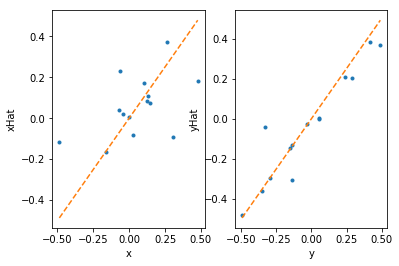

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

x = gt_joints[0][:,0]
xhat = predicted_joints[0][:,0]
y = gt_joints[0][:,1]
yhat = predicted_joints[0][:,1]


plt.subplot(121)
plt.plot(x,xhat,'.')
plt.xlabel('x');plt.ylabel('xHat');
plt.plot([min(x), max(x)], [min(x), max(x)],'--')
plt.subplot(122)
plt.plot(y,yhat,'.')
plt.plot([min(y), max(y)], [min(y), max(y)],'--')
plt.xlabel('y');plt.ylabel('yHat');

In [7]:
# save predicted joints coordination to prectedJointsLSP_1000_14.txt
n, numJoints, dim = predicted_joints.shape
np.savetxt('prectedJointsLSP_{}_{}.txt'.format(n,numJoints),predicted_joints.reshape(-1,numJoints*dim), delimiter=',')

# TODO: convert to image coordinate before saving!


In [8]:
# calc PCP
for ext in np.linspace(1.0, 2.0, 6, True):
    print('\n====================')
    print('BBOX EXTENSION:', ext)
    test_dataset.bbox_extension_range = (ext, ext)
    

    # calc metric
    scripts.regressionnet.calc_pcp(global_step, gt_joints, gt_joints_is_valid, predicted_joints, orig_bboxes, dataset_name)
        
    """
    scripts.regressionnet.evaluate_pcp(net, pose_loss_op, test_iterator, None,
                                       dataset_name=dataset_name,
                                       tag_prefix='test')
    """


BBOX EXTENSION: 1.0
met


/home/yyoo/src/deeppose/poseevaluation/pcp.py:88: RuntimeWarning: divide by zero encountered in float_scalars
  gt_joints[i]['sticks'][stick_id, :2]) / gt_stick_len
/home/yyoo/src/deeppose/poseevaluation/pcp.py:90: RuntimeWarning: divide by zero encountered in float_scalars
  gt_joints[i]['sticks'][stick_id, 2:]) / gt_stick_len


Step	 1000000	 test/mPCP	 0.348
Step 1000000 test/parts_PCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.231	0.858	0.246	0.074	0.495	0.185	0.348
met


/home/yyoo/src/deeppose/poseevaluation/pcp.py:51: RuntimeWarning: divide by zero encountered in float_scalars
  gt_joints[i]['sticks'][stick_id, :2]) / gt_stick_len
/home/yyoo/src/deeppose/poseevaluation/pcp.py:53: RuntimeWarning: divide by zero encountered in float_scalars
  gt_joints[i]['sticks'][stick_id, 2:]) / gt_stick_len


Step	 1000000	 test/mRelaxedPCP	 0.482
Step 1000000 test/parts_RelaxedPCP:
Head	Torso	U Arm	L Arm	U Leg	L Leg	mean
0.366	0.929	0.382	0.162	0.699	0.354	0.482
met


KeyError: 'met'

### Test one image

In [9]:
# code from regressionnet.fill_joint_feed_dict
def fill_joint_feed_dict(net, batch_feeds,
                         conv_lr=None, fc_lr=None,
                         phase='test', train_keep_prob=0.4):
    """Fills the feed_dict for training the given step.

    A feed_dict takes the form of:
    feed_dict = {
        <placeholder>: <tensor of values to be passed for placeholder>,
        ....
    }

    Args:
      batch_loader: BatchLoader, that provides batches of the data
      images_pl: The images placeholder, from placeholder_inputs().
      labels_pl: The labels placeholder, from placeholder_inputs().

    Returns:
      feed_dict: The feed dictionary mapping from placeholders to values.
    """
    if phase not in ['train', 'test']:
        raise ValueError('phase must be "train" or "test"')
    if phase == 'train':
        keep_prob = train_keep_prob
        is_phase_train = True
    else:
        keep_prob = 1.0
        is_phase_train = False

    if len(batch_feeds) != 3:
        raise ValueError('feeds must contain only 3 elements: images, joints_gt, joints_is_valid')
    images, joints_gt, joints_is_valid = batch_feeds

    feed_dict = {
        net.x: images,
        'pose_input/joints_gt:0': joints_gt,
        'pose_input/joints_is_valid:0': joints_is_valid,
        'input/is_phase_train:0': is_phase_train,
        'lr/conv_lr:0': conv_lr,
        'lr/fc_lr:0': fc_lr
    }

    try:
        keep_prob_pl = net.graph.get_tensor_by_name('input/dropout_keep_prob:0')
        dropout_params = {keep_prob_pl: keep_prob}
    except KeyError:
        dropout_params = {'fc6/keep_prob_pl:0': keep_prob,
                          'fc7/keep_prob_pl:0': keep_prob}
    feed_dict.update(dropout_params)
    return feed_dict

In [10]:
# code from regressionnet.evaluate_pcp
summary_writer = None
tag_prefix='test'

total_loss = 0.0

num_joints = int(int(net.fc_regression.get_shape()[1]) / 2)
gt_joints = list()
gt_joints_is_valid = list()
predicted_joints = list()
orig_bboxes = list()
    

test_it = copy.copy(test_iterator)
num_test_examples = len(test_it.dataset)
num_batches = int(math.ceil(num_test_examples / test_it.batch_size))
for i, batch in tqdm(enumerate(test_it), total=num_batches):

        # uncomment a breakpoint here for debugging
        # import pdb; pdb.set_trace()

        feeds = batch2feeds(batch)
        feed_dict = fill_joint_feed_dict(net,
                                         feeds[:3],
                                         conv_lr=0.0,
                                         fc_lr=0.0,
                                         phase='test')

        pred_j, batch_loss_value = net.sess.run([net.fc_regression, pose_loss_op], feed_dict=feed_dict)
        total_loss += batch_loss_value * len(batch)
        predicted_joints.append(pred_j.reshape(-1, num_joints, 2))

        gt_joints.append(feeds[1])
        gt_joints_is_valid.append(feeds[2])
        orig_bboxes.append(np.vstack([x['bbox'] for x in feeds[3]]))

100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


In [11]:
# estimated joints
imageIdx = 0
print(predicted_joints[imageIdx][0].shape)
print(predicted_joints[imageIdx][0])
xhat = predicted_joints[imageIdx][0][:,0]
yhat = predicted_joints[imageIdx][0][:,1]

(14, 2)
[[ 0.0407089   0.3806074 ]
 [ 0.17958258  0.20943275]
 [ 0.07427576  0.00545968]
 [-0.08009227 -0.00227182]
 [ 0.01816968  0.20226538]
 [-0.11418964  0.3692826 ]
 [ 0.3731125  -0.02807535]
 [ 0.2295722  -0.13289729]
 [ 0.16965462 -0.2970011 ]
 [-0.08978064 -0.3084688 ]
 [-0.16417868 -0.14635842]
 [ 0.00417539 -0.04049177]
 [ 0.08198261 -0.36346698]
 [ 0.10979187 -0.48000896]]


In [12]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline


# plot example image (normalized)
img, joints, is_valid_joints, misc = test_dataset.get_example(imageIdx, gcn=None, bbox_extension_range=None, shift=None)
print(joints)

#img = test_dataset.get_original_image(imageIdx)  # 169 95 3


h,w,d=img.shape
print(h,w,d)    # 227 227 3

x = joints[:,0]
print([min(x), max(x)])
y = joints[:,1]
print([min(y), max(y)])

#cv2.imshow('image',img)
#if cv2.waitKey(10) & 0xFF == 27:
#        print("quit")
#        break
#cv2.destroyAllWindows()

[[-0.06828195  0.42070484]
 [ 0.47797358  0.24008811]
 [ 0.14757711  0.05066079]
 [ 0.02422905  0.05066079]
 [-0.04185021  0.28854626]
 [-0.48678413  0.49118942]
 [ 0.26211452 -0.03303966]
 [-0.06387666 -0.13876653]
 [ 0.10352421 -0.29735684]
 [ 0.30616742 -0.13876653]
 [-0.16079295 -0.15198237]
 [ 0.00220263 -0.32819384]
 [ 0.12555069 -0.35462555]
 [ 0.12995595 -0.49559471]]
227 227 3
[-0.4867841303348541, 0.4779735803604126]
[-0.49559471011161804, 0.4911894202232361]


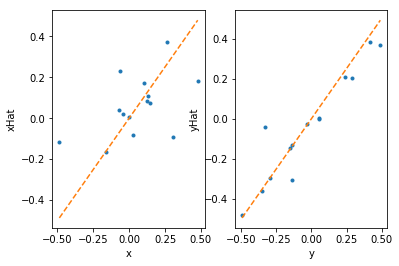

In [13]:
plt.subplot(121)
plt.plot(x,xhat,'.')
plt.xlabel('x');plt.ylabel('xHat');
plt.plot([min(x), max(x)], [min(x), max(x)],'--')
plt.subplot(122)
plt.plot(y,yhat,'.')
plt.plot([min(y), max(y)], [min(y), max(y)],'--')
plt.xlabel('y');plt.ylabel('yHat');

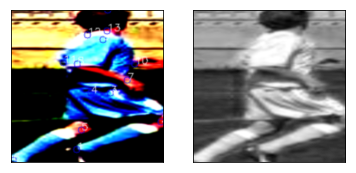

In [14]:
def plotJoints(img, joints, color=(255,255,255)):
    img = img.copy()
    numJoints, t = joints.shape
    #numJoints, t = predicted_joints[0].shape #joints.shape
    #print(numJoints,t)

    circSize=10
    font = cv2.FONT_HERSHEY_SIMPLEX

    #cv2.drawKeypoints(img,joints,img)
    for i in range(numJoints):
        #print(joints[i,:])
        x = joints[i,0]
        y = joints[i,1]
        #x = predicted_joints[0][0][i,0]
        #y = predicted_joints[0][0][i,1]

        # transform 
        xx = int(w/2 + w*x)
        yy = int(h/2 + h*y)    
        #print(x,y)

        cv2.circle(img, (xx, yy), 5, color) #, -1)

        cv2.putText(img, str(i+1), (xx,yy), font, 0.5, (255,255,255), 1, cv2.LINE_AA)
    #    cv2.text(img, (x, y), 5, (255, 0, 0)) #, -1)
        # https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
    
    return img 

plt.subplot(121)
img1=plotJoints(img,joints, (255,0,0))
plt.imshow(img1[:,:,::-1], interpolation = 'bicubic')
#plt.imshow(img[:,:,0], cmap='gray', interpolation = 'bicubic')

plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.subplot(122)
plotJoints(img, predicted_joints[imageIdx][0])
#plt.imshow(img[:,:,::-1], cmap = 'gray', interpolation = 'bicubic')
plt.imshow(img[:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.show()


(227, 227, 3)


/home/yyoo/tf3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


ValueError: Images of type float must be between -1 and 1.

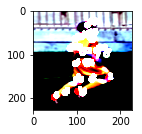

In [82]:
#plt.imshow(img, vmin = -2, vmax = 2)
#plt.show()
print(img.shape)
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.imshow(img, cmap='gray', vmin = -2, vmax = 2, interpolation = 'bicubic')
#ax.autoscale(True)



In [98]:
#print(img*0.5)
I = np.minimum(np.maximum(img*0.5,-1),1)
print(I)

from skimage import data, io, filters
io.imshow(I)
io.show()

[[[ 0.5842837   0.70071435  0.69304544]
  [ 0.5758691   0.688076    0.682609  ]
  [ 0.55903983  0.66279924  0.6617362 ]
  ...
  [ 0.44123477  0.5743307   0.6408633 ]
  [ 0.4244055   0.54905397  0.6408633 ]
  [ 0.4244055   0.54905397  0.6408633 ]]

 [[ 0.5758691   0.688076    0.682609  ]
  [ 0.56745446  0.6754376   0.6721726 ]
  [ 0.55062515  0.6501609   0.6512997 ]
  ...
  [ 0.44123477  0.5616923   0.6408633 ]
  [ 0.4244055   0.54905397  0.6408633 ]
  [ 0.4244055   0.54905397  0.6408633 ]]

 [[ 0.55062515  0.6501609   0.6617362 ]
  [ 0.55062515  0.6501609   0.6512997 ]
  [ 0.5422105   0.6375225   0.6408633 ]
  ...
  [ 0.44123477  0.5616923   0.6408633 ]
  [ 0.4244055   0.54905397  0.6408633 ]
  [ 0.4244055   0.5364156   0.6408633 ]]

 ...

 [[-0.4423029  -0.28507835 -0.38190582]
  [-0.4423029  -0.28507835 -0.38190582]
  [-0.45071757 -0.29771674 -0.39234224]
  ...
  [-0.5516933  -0.44937715 -0.49670646]
  [-0.5516933  -0.44937715 -0.49670646]
  [-0.5516933  -0.4367388  -0.49670646]]

 [

/home/yyoo/tf3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


ValueError: Floating point image RGB values must be in the 0..1 range.

### Example to get test data

In [31]:
#print(test_iterator)
test_iterator = iterators.MultiprocessIterator(
    test_dataset, batch_size=128,
    repeat=False, shuffle=False,
    n_processes=1, n_prefetch=1)
# http://docs.chainer.org/en/stable/reference/generated/chainer.iterators.MultiprocessIterator.html

for i, batch in enumerate(test_iterator): 
    print(i, batch)

0 [(array([[[ 1.1685674 ,  1.4014287 ,  1.3860909 ],
        [ 1.1517382 ,  1.376152  ,  1.365218  ],
        [ 1.1180797 ,  1.3255985 ,  1.3234724 ],
        ...,
        [ 0.88246953,  1.1486614 ,  1.2817266 ],
        [ 0.848811  ,  1.0981079 ,  1.2817266 ],
        [ 0.848811  ,  1.0981079 ,  1.2817266 ]],

       [[ 1.1517382 ,  1.376152  ,  1.365218  ],
        [ 1.1349089 ,  1.3508753 ,  1.3443452 ],
        [ 1.1012503 ,  1.3003218 ,  1.3025994 ],
        ...,
        [ 0.88246953,  1.1233846 ,  1.2817266 ],
        [ 0.848811  ,  1.0981079 ,  1.2817266 ],
        [ 0.848811  ,  1.0981079 ,  1.2817266 ]],

       [[ 1.1012503 ,  1.3003218 ,  1.3234724 ],
        [ 1.1012503 ,  1.3003218 ,  1.3025994 ],
        [ 1.084421  ,  1.275045  ,  1.2817266 ],
        ...,
        [ 0.88246953,  1.1233846 ,  1.2817266 ],
        [ 0.848811  ,  1.0981079 ,  1.2817266 ],
        [ 0.848811  ,  1.0728312 ,  1.2817266 ]],

       ...,

       [[-0.8846058 , -0.5701567 , -0.76381165],
       

In [32]:
def get_gt_data(test_iterator):
    test_it = copy.copy(test_iterator)
    num_test_examples = len(test_it.dataset)
    num_batches = int(math.ceil(num_test_examples / test_it.batch_size))
    gt_joints = list()
    gt_joints_is_valid = list()
    orig_bboxes = list()

    print(len(test_it.dataset))
    for i, batch in tqdm(enumerate(test_it), total=num_batches):
        feeds = batch2feeds(batch)
        gt_joints.append(feeds[1])
        gt_joints_is_valid.append(feeds[2])
        orig_bboxes.append(np.vstack([x['bbox'] for x in feeds[3]]))

    gt_joints = np.vstack(gt_joints)
    gt_joints_is_valid = np.vstack(gt_joints_is_valid)
    orig_bboxes = np.vstack(orig_bboxes)
    return gt_joints, gt_joints_is_valid, orig_bboxes

In [33]:
test_iterator = iterators.MultiprocessIterator(
    test_dataset, batch_size=128,
    repeat=False, shuffle=False,
    n_processes=1, n_prefetch=1)
# http://docs.chainer.org/en/stable/reference/generated/chainer.iterators.MultiprocessIterator.html

gt_joints, gt_joints_is_valid, orig_bboxes = get_gt_data(test_iterator)

print(gt_joints.shape)
print(gt_joints_is_valid.shape)
print(orig_bboxes.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


(1, 14, 2)
(1, 14, 2)
(1, 4)


In [34]:
orig_bboxes

array([[  0,   0,  95, 169]])

In [35]:
print(test_dataset)